## Initial plan for training an SAE on spikes and trying to find interpretable SAE features

- [x] Get neural + behavioral data
  - [x] Get Allen visual coding neuropixels spikes data
  - [x] Get Allen visual stim data + metadata
- Train SAEs 
  - [x] Break spikes down into time windows
  - [x] Train SAEs on all spikes for a particular region for all sessions for one animal
- [x] Interpret SAE features
  - [x] After training, feed in spikes for particular time window(s) and see which SAE feature(s) fire, and see if they correspond to the visual stim
- Validate SAEs
  - [x] Visualize reconstructions
  - [x] Validate reconstructions (e.g. cosine similarity between reconstructions and true spikes)
  - [x] Validate sparsity (% active features over % time active)


## Example MINI pipeline on new data:

- Train/val/test split
- Train + hyperparam sweep SAE with k-fold crossval
- Validate SAE (on train + val data)
    - Validate that SAE features are sparse
      - Histogram of L0 (prob active for % of active features)
    - Validate that reconstructions are good
      - $R^2$ for total number of spikes summed over all neurons for each example
      - Cosine similarity for vector of reconstructions to vector of actual for each example
- Find k top-ranked SAE features (e.g. features with the highest mean N activation values, or features that are most important to reconstruction (i.e. when removed, reconstruction suffers the most) )
  - For each top-k SAE feature, (semi-automatically?) scour data / metadata to find corresponding natural feature
    - Essentially create a confusion matrix for natural vs. SAE feature: for all occurrences of natural feature, see co-occurrence rate of top-responding SAE features; for all occurrences of SAE feature, see co-occurrence rate of natural feature
- Validate top-k SAE features (on test data)
    - Again create natural vs. SAE feature confusion matrix, as was done above for train + val data
    - Show that the neurons and spikes that contribute to an SAE feature can decode the natural feature:
      - Roughly equivalent to decoding that takes into account *all* spikes ? 
      - OR (only do the following if the above fails) better than
        1. The top n neurons most correlated (highest firing) with the natural feature
        2. And/or the top n neurons that contribute to the SAE feature


### Two types of usecases

1. Given neural and behavioral data, find novel natural features encoded by characteristic neural activity patterns (found via SAE features) - this could be semi-automated

2. Given a set of natural features, see if there are neural activity patterns (via SAE features) that encode them - this could be fully automated! (but is not that different than doing something like a linear bayesian decoder)

## Potential future plans

- Neural data variants
    - Time window size
    - Add a sequence length?

- SAE arch variants
    - Number of SAE features
    - Multi-layer decoder

- SAE training variants
    - jump-relu SAE
    - Matryoshka SAE
    - [x] batch-topk SAE
    - [x] Loss function changes
        - [x] Try folding decoder weight norm into loss: https://transformer-circuits.pub/2024/april-update/index.html#training-saes
        - Sparsity 
            - [x] L1_coeff values
            - [x] batch-topk SAE
            - tanh penalty https://transformer-circuits.pub/2024/feb-update/index.html#dict-learning-tanh
        - Reconstruction
            - [x] LMSE loss
            - [x] Poisson KL loss
    - Different optimizers

- SCCs
    - Feature diffing between animals?
    - Feature diffing on same animal at two different snapshots?
    - Cross-region prediction with some time lag?

## Initial Sweeps

This is all assuming 100-400 units over ~ 2e5 to 1e6 examples.

### Neural data

- Time window size (50 ms -- fixed for now)
- Unit preprocessing (remove units with firing rate < 0.5 Hz, isi violations > 0.1 -- fixed for now)
- Sequence length -- feed in previous info, but only try to reconstruct current info: (0 - 4 previous windows)

### SAEs

- Number of neurons (5e3, 1e4, 2e4, 5e4, 1e5)
- Optimizer learning rate (lr: 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
- LR schedule (simple cosine cycle): true or false
- Loss functions
    - Batchtopk SAE (k: 25, 50, 100, 200)
        - L2 loss MSE
        - L2 loss LMSE (t: 0.9, 0.95, 1, 1.05, 1.1)
    - Non-topk
        - L2 loss MSE
        - L2 loss LMSE (t: 0.9, 0.95, 1, 1.05, 1.1)
        - L2 loss PKL
        - Sparsity losses:
            - l1_loss_standard (lambda: 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3)
            - l1_loss_decoder_norm (lambda: 5e-6, 1e-5, 5e-4, 1e-3)
            - tanh_loss (lambda: 5e-6, 1e-5, 5e-5, 1e-4, 5e-3; B: 0.2, 0.4, 0.6, 0.8, 1) ?

Report during sweep:

- loss
- L0
- lr
- n_dead

Report end of sweep:

- mean, median L0 of examples (plus histogram of L0)
- R^2 of summed spike counts
- mean, median R^2 for each neuron over all examples (plus distribution of these values)
- n_dead

---


- One job for each loss for all batchtopk saes (4 jobs: 4 * 4 * 7 = 112 sweeps per run)
- One job for each non-topk l2 loss functions (7 jobs: 4 * 4 * 4 * 4 * 5 = 1280 sweeps per job)

In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [2]:
"""Import packages."""

import math
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, List, Optional, Tuple

import jax
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import torch as t
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

## Get Allen visual coding neuropixels data

In [3]:
"""Set paths."""

out_dir = Path(r"C:\Users\jai\mini\data")
out_dir.mkdir(exist_ok=True)
print(f"{out_dir.exists()=}")

manifest_path = out_dir / "manifest.json"
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

out_dir.exists()=True


In [4]:
movie_one = cache.get_natural_movie_template(1)
movie_three = cache.get_natural_movie_template(3)
image_117 = cache.get_natural_scene_template(117)

movie_one.shape, movie_three.shape, image_117.shape

((900, 304, 608), (3600, 304, 608), (918, 1174))

In [4]:
"""Get metadata."""

units = cache.get_units()
probes = cache.get_probes()
channels = cache.get_channels()
sessions = cache.get_session_table()

In [5]:
sessions[np.logical_and(sessions["unit_count"] > 800, sessions["session_type"] == "brain_observatory_1.1")]

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
742951821,2019-10-03T00:00:00Z,723627604,brain_observatory_1.1,120.0,M,wt/wt,893,2219,6,"[VISal, nan, grey, VISl, VISrl, VISp, VISpm, VIS]"
750332458,2019-10-03T00:00:00Z,726141251,brain_observatory_1.1,91.0,M,wt/wt,902,2216,6,"[grey, VISrl, nan, VISal, IntG, IGL, LGd, CA3,..."
751348571,2019-10-03T00:00:00Z,732548380,brain_observatory_1.1,93.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,859,2217,6,"[grey, LGv, CA3, DG, CA1, VISl, nan, APN, POL,..."
754829445,2019-10-03T00:00:00Z,726298253,brain_observatory_1.1,141.0,M,wt/wt,832,1851,5,"[PoT, LP, LGd, CA3, DG, CA1, VISp, nan, VPM, C..."
757216464,2019-10-03T00:00:00Z,733457989,brain_observatory_1.1,105.0,M,wt/wt,959,2225,6,"[LP, DG, CA3, CA1, VISrl, nan, PO, LGd, HPF, V..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"
798911424,2019-10-03T00:00:00Z,775876828,brain_observatory_1.1,110.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,825,2233,6,"[APN, TH, Eth, LP, DG, HPF, CA3, CA1, VISrl, n..."


In [5]:
"""Choose a session and load in the data."""

# session = sessions[sessions["specimen_id"] == 742951821]
# session = sessions[sessions["specimen_id"] == 750332458]
# session = sessions[sessions["specimen_id"] == 717038288]
session = sessions[sessions.index == 732592105]
display(session)
session_id = session.index.values[0]
print(f"{session_id=}")
session_data = cache.get_session_data(session_id)

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"


session_id=732592105


c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Some useful (not exhaustive) `session_data` attributes and methods

- Attributes:
  - metadata
  - channels
  - stimulus_conditions
  - stimulus_presentations
  - spike_times
  - spike_amplitudes

- Methods:
  - channel_structure_intervals
  - conditionwise_spike_statistics
  - get_pupil_data 
  - get_stimulus_epochs
  - get_stimulus_parameter_values
  - get_stimulus_table
  - get_lfp
  - get_screen_graze_data
  - get_invalid_times
  - presentationwise_spike_times
  - presentationwise_spike_counts
  - running_speed

In [ ]:
display(session_data.metadata)

In [ ]:
"""View units metadata."""

regions = ["VISp", "VISpm", "VISl", "VISli", "VISrl", "VISal"]
units_df = session_data.units
region_units = units_df[units_df["structure_acronym"].isin(regions)]
display(region_units)

In [ ]:
region_units.columns

In [ ]:
region_units = region_units[region_units["firing_rate"] > 0.5]
region_units = region_units[region_units["isi_violations"] < 0.1]
print(len(region_units))

In [ ]:
"""Get spikes for units within specified region."""

spike_times = session_data.spike_times
region_unit_ids = set(region_units.index)
region_spike_times = {
    unit_id: spikes
    for unit_id, spikes in spike_times.items()
    if unit_id in region_unit_ids
}
display(region_spike_times)

In [ ]:
"""See total number of spikes, and the maximum number of spikes in a single unit."""

region_unit_spike_counts = {len(ts) for ts in region_spike_times.values()}
sum(region_unit_spike_counts), max(region_unit_spike_counts)

Options for feeding in spikes:
- Total spike counts per unit in a small time window

In [ ]:
"""Format spikes data for SAE: binned spike counts."""

win = 0.05  # seconds
stop_time = session_data.stimulus_presentations.iloc[-1]["stop_time"]
time_bins = np.arange(0, stop_time, win)

# Get spike counts for all units for each timebin via histogram2d
all_spike_ts = np.concatenate(list(region_spike_times.values()))
unit_indices = np.concatenate(  # for each spike
    [np.full(len(spikes), i) for i, spikes in enumerate(region_spike_times.values())]
)
unit_bins = np.arange(len(region_spike_times) + 1)
counts, _, _ = np.histogram2d(
    all_spike_ts, unit_indices, bins=[time_bins, unit_bins]
)
counts = t.from_numpy(counts.astype(np.uint8))
n_examples, n_units = counts.shape

In [ ]:
"""Check sparsity of binned spike counts."""

frac_nonzero_bins = t.sum(counts > 0) / counts.numel()
spike_counts_per_bin = reduce(counts, "example unit -> example", "sum")
frac_nonzero_examples = sum(spike_counts_per_bin > 0) / spike_counts_per_bin.shape[0]
print(f"{frac_nonzero_bins=}\n{frac_nonzero_examples=}")

In [ ]:
"""Convert to sparse tensor."""

# Get nonzero idxs in appropriate format for `sparse_coo_tensor`
idxs = rearrange(t.nonzero(counts), "example orig_coord -> orig_coord example")
vals = counts[idxs[0], idxs[1]]
counts = t.sparse_coo_tensor(idxs, vals, t.Size(counts.shape))
print(counts)

In [ ]:
"""View binned spike counts as df."""

counts_df = pd.DataFrame(
    counts.to_dense(),
    columns=region_spike_times.keys(),  # unit IDs as column names
    index=time_bins[:-1],  # bin start times as index
)

display(counts_df)

In [ ]:
"""Save `counts_df`."""

save_dir = out_dir / "sessions_proc" / str(session_id)
save_dir.mkdir(parents=True, exist_ok=True)
counts_df.to_csv(save_dir / "spike_counts.csv")

In [7]:
"""Load `counts_df`."""

save_dir = out_dir / "sessions_proc" / str(session_id)
counts_df = pd.read_csv(save_dir / "spike_counts.csv", index_col=0)
display(counts_df)

,915957951,915957946,915958108,915958104,915958534,915958067,915958058,915958122,915958824,915958211,...,915966384,915966556,915966611,915966322,915966645,915966529,915966526,915966523,915966568,915966387
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143.15,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,2
9143.20,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,3
9143.25,1,2,0,5,0,5,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
9143.30,0,0,0,1,0,0,0,0,2,1,...,0,0,0,0,0,1,0,1,0,4


## Train the SAE

In [8]:
"""Check torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")
if device.type == "cuda":
    print(t.cuda.get_device_name(0))

device=device(type='cuda')
NVIDIA GeForce RTX 3090


In [9]:
"""Get amount of free memory in gb in torch device."""

t.cuda.get_device_properties(device).total_memory / 1e9 - (
    (t.cuda.memory_allocated(device) / 1e9) + (t.cuda.memory_reserved(device) / 1e9)
)

25.769279488

In [10]:
"""Estimate gb required for largest tensor op."""

n_units = counts_df.shape[1]
batch_sz, n_instances, seq_len, n_hidden_ae = 256, 2, 1, 10_000

# matmul for encoder (equivalent to decoder)
(
    (batch_sz * n_instances * n_units * seq_len) 
    + (n_instances * n_units * n_hidden_ae * seq_len) 
    + (batch_sz * n_instances * n_hidden_ae * seq_len) 
    * 2
) / 1e9

0.014875712

In [11]:
"""Create SAE for taking binned spike counts."""

@dataclass
class SaeConfig:
    """Config class to set some params for SAE."""
    n_input_ae: int  # number of input units to the autoencoder
    n_hidden_ae: int  # number of hidden units in the autoencoder
    n_instances: int = 2  # number of model instances to optimize in parallel
    topk: Optional[int] = None  # avg num of contributing sae features per example in a batch


class Sae(nn.Module):
    """SAE model for learning sparse representations of binned spike counts."""
    # Shapes of weights and biases for the encoder and decoder in the single-layer SAE.
    W_enc: Float[Tensor, "inst in_ae hidden_ae"]
    W_dec: Float[Tensor, "inst hidden_ae in_ae"]
    b_enc: Float[Tensor, "inst hidden_ae"]
    b_dec: Float[Tensor, "inst in_ae"]

    def __init__(self, cfg: SaeConfig):
        """Initializes model parameters."""
        super().__init__()
        self.cfg = cfg
        
        # Tied weights initialization to reduce dead neurons (https://arxiv.org/pdf/2406.04093).
        self.W_enc = t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae), dtype=bfloat16)
        # self.W_enc = nn.Parameter(nn.init.xavier_normal_(self.W_enc))
        self.W_enc = nn.init.kaiming_normal_(self.W_enc, mode="fan_in", nonlinearity="relu")
        self.W_dec = rearrange(self.W_enc, "inst hidden_ae in_ae -> inst in_ae hidden_ae").clone()
        self.W_enc, self.W_dec = nn.Parameter(self.W_enc), nn.Parameter(self.W_dec)
        
        self.b_enc = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_hidden_ae), dtype=bfloat16))
        self.b_dec = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_input_ae), dtype=bfloat16))

    def forward(self, x: Float[Tensor, "batch inst in_ae"]) -> (
        Tuple[Float[Tensor, "batch inst hidden_ae"], Float[Tensor, "batch inst in_ae"]]
    ):
        """Computes loss as a function of SAE feature sparsity and spike_count reconstructions."""
        # Compute encoder hidden activations.
        z = einsum(x, self.W_enc, "batch inst in_ae, inst hidden_ae in_ae -> batch inst hidden_ae")
        z = F.relu(z + self.b_enc)
        if self.cfg.topk:
            # Batch topk: only keep the (top k features * batch_sz) in the batch.
            batch_topk = z.shape[0] * self.cfg.topk
            feat_keep_vals, feat_keep_idxs = z.ravel().topk(batch_topk)
            z = z.ravel().zero_().scatter_(0, feat_keep_idxs, feat_keep_vals).view_as(z)

        # Compute reconstructed input.
        x_prime = (
            einsum(z, self.W_dec, "batch inst hidden_ae, inst in_ae hidden_ae -> batch inst in_ae")
            + self.b_dec
        )

        return x_prime, z

In [12]:
"""Add methods (that only get used for certain variants) to norm W_dec and resample dead neurons."""

@t.no_grad()
def normalize_decoder(self: Sae):
    """Unit norms the decoder weights."""
    self.W_dec.data = self.W_dec.data / (self.W_dec.data.norm(dim=1, keepdim=True) + 1e-6)

@t.no_grad()
def resample_neurons(
    self: Sae,
    frac_active: Float[Tensor, "window inst hidden_ae"],
) -> Tuple[List[List[str]], str]:  # -> (colors_for_neurons, title_with_resampling_info)
    """Resamples dead neurons according to `frac_active`."""
    # Get a tensor of dead neurons.
    dead_features_mask = (
        reduce(frac_active, "window inst hidden_ae -> inst hidden_ae", "sum") < 1e-4
    )
    n_dead = dead_features_mask.sum().item()

    frac_dead = n_dead / dead_features_mask.numel()

    print(f"{frac_dead=}")
    # return [["black"] * len(dead_features_mask)], f"{n_dead} neurons to resample"

    if frac_dead < 0.1:
        return [["black"] * len(dead_features_mask)], "no dead neurons to resample"

    # Create new weights
    replacements = t.randn((n_dead, self.cfg.n_input_ae), device=self.W_enc.device, dtype=bfloat16)
    # normalize to match existing weight scale
    current_weight_scale = self.W_enc[~dead_features_mask].norm(dim=-1).mean()
    replacements_norm = (
        replacements * (current_weight_scale / (replacements.norm(dim=-1, keepdim=True) + 1e-6))
    )
    
    # Update weights
    with t.no_grad():
        new_W_enc = self.W_enc.clone()
        new_W_enc[dead_features_mask] = replacements_norm
        self.W_enc.copy_(new_W_enc)
        self.W_dec.copy_(rearrange(self.W_enc, "inst hidden_ae in_ae -> inst in_ae hidden_ae"))
        self.b_enc[dead_features_mask].fill_(0.0)

    colors = [
        ["red" if dead else "black" for dead in dead_neuron_mask_inst]
        for dead_neuron_mask_inst in dead_features_mask
    ]
    title = f"resampling {n_dead}/{dead_features_mask.numel()} neurons (shown in red)"
    return colors, title

# Add methods to sae class.
Sae.normalize_decoder = normalize_decoder
Sae.resample_neurons = resample_neurons

In [13]:
"""Create possible loss functions for reconstruction and sparsity."""

# Loss functions for reconstruction.

def lmse(
    x: Float[Tensor, "batch inst in_ae"],  # input
    x_prime: Float[Tensor, "batch inst in_ae"],  # reconstruction
    tau: int = 1,  # relative overestimation/underestimation penalty (1 for symmetric)
) -> Float[Tensor, "batch inst in_ae"]:
    """Computes the log mean squared error loss between true input and reconstruction."""
    return reduce(
        (tau * t.log(x_prime + 1) - t.log(x + 1)).pow(2), "batch inst in_ae -> batch inst", "mean"
    )


def pkl(
    x: Float[Tensor, "batch inst in_ae"],  # input
    x_prime: Float[Tensor, "batch inst in_ae"],  # reconstruction
    eps: float = 1e-6,  # small constant to prevent log(0)
) -> Float[Tensor, "batch inst in_ae"]:
    """Computes the Poisson KL divergence between true input and reconstruction."""
    x, x_prime = x + eps, x_prime + eps
    return reduce(
        x * t.log(x / x_prime) + x_prime - x, "batch inst in_ae -> batch inst", "mean"
    )


def mse(
    x: Float[Tensor, "batch inst in_ae"],  # input
    x_prime: Float[Tensor, "batch inst in_ae"],  # reconstruction
) -> Float[Tensor, "batch inst in_ae"]:
    """Computes the mean squared error loss between true input and reconstruction."""
    return reduce((x - x_prime).pow(2), "batch inst in_ae -> batch inst", "mean")

# Loss functions for sparsity.

def l1_loss(
    z: Float[Tensor, "batch inst hidden_ae"],  # hidden activations
    lamda: float = 1e-5,  # sparsity penalty coefficient
) -> Float[Tensor, "batch inst"]:
    """Computes sparsity penalty based on the l1 norm of the activations."""
    return lamda * reduce(z.abs(), "batch inst hidden_ae -> batch inst", "sum")


def l1_loss_decoder_norm(
    z: Float[Tensor, "batch inst hidden_ae"],  # hidden activations
    W_dec: Float[Tensor, "inst in_ae hidden_ae"],  # decoder weights
    lamda: float = 1e-5,   # sparsity penalty coefficient
) -> Float[Tensor, "batch inst"]:
    """Computes sparsity penalty based on the norm of a feature's decoder weights. 
    
    Where each of these feature norms is modulated by the l1 norm of the respective activation.
    See https://transformer-circuits.pub/2024/april-update/index.html#training-saes for details.
    """
    sparsity_loss = einsum(
        z.abs(), t.norm(W_dec, p=2, dim=1), "batch inst hidden_ae, inst hidden_ae -> batch inst"
    )
    return lamda * sparsity_loss


def tanh_loss(
    z: Float[Tensor, "batch inst hidden_ae"],  # hidden activations
    W_dec: Float[Tensor, "inst in_ae hidden_ae"],  # decoder weights
    lamda: float = 1.0,  # sparsity penalty coefficient
    A: float = 1.0,  # tanh sparsity penalty scaling factor
    B: float = 1.0  # tanh saturation scaling factor
 ) -> Float[Tensor, "batch inst"]:
    """Computes sparsity penalty using tanh to combat shrinkage of meaningful activations.

    See https://transformer-circuits.pub/2024/feb-update/index.html#dict-learning-tanh for details.
    """
    sparsity_loss = l1_loss_decoder_norm(z, W_dec, lamda)
    return (A / B) * t.tanh(B * sparsity_loss)


In [ ]:
"""Create lr schedule function."""

def lr_schedule(step: int, n_steps: int, initial_lr: float, min_lr: float):
    """Learning rate schedule with warmup, decay and cosyne cycle."""
    n_warmup_steps = int(n_steps * 0.1)
    decay_start_step = int(n_steps * 0.5)
    n_decay_steps = n_steps - decay_start_step
    n_cycle_steps = int(n_decay_steps * 0.2)
    
    # Warmup phase
    if step < n_warmup_steps:
        return max(initial_lr * (step / n_warmup_steps), min_lr)
    
    # Decay phase: cosine decay with cycles
    if step >= decay_start_step:
        decay_steps = n_steps - decay_start_step
        decay_position = (step - decay_start_step) / decay_steps
        cosine_decay = 0.5 * (1 + math.cos(math.pi * decay_position))
        decayed_lr = min_lr + (initial_lr - min_lr) * cosine_decay
        cycle_position = ((step - decay_start_step) % n_cycle_steps) / n_cycle_steps
        cycle_factor = 0.5 * (1 + math.cos(2 * math.pi * cycle_position))
        cycle_amplitude = 0.1 * (initial_lr - min_lr)
            
        return decayed_lr + cycle_amplitude * cycle_factor

    # Constant phase: between warmup and decay start
    return initial_lr

In [36]:
"""Create optimization function"""

def optimize(
    model: Sae,
    optimizer: t.optim.Optimizer,
    spike_counts: Int[Tensor, "n_examples n_units"],
    batch_sz: int,
    n_steps: int,
    log_freq: int,
    seq_len: int,  # number of timebins to use in each spike_count_seq
    use_lr_schedule: bool = False,
    neuron_resample_window: Optional[int] = None,  # in number of steps
):
    """Optimizes the autoencoder using the given hyperparameters."""
    # Create lists to store data we'll eventually be plotting.
    frac_active_list = []  # fraction of non-zero activations for each neuron (feature)
    data_log = {
        "frac_active": [],
        "W_enc": [],
        "W_dec": [],
        "titles": [],
        "colors": [],
        "loss": [],
    }
    colors = None
    title = "No resampling"

    # Define valid samples for `spike_counts`.
    n_examples, _n_units = spike_counts.shape
    valid_starts = n_examples - seq_len + 1

    if use_lr_schedule:
        init_lr = optimizer.param_groups[0]["lr"]
        min_lr = init_lr * 1e-2

    pbar = tqdm(range(n_steps))
    for step in pbar:
        # Check for dead neurons, and resample them if found, if we're less than halfway through.
        if (
            (neuron_resample_window is not None) 
            and ((step + 1) % neuron_resample_window == 0)
            and (step < n_steps // 2)
        ):
            frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
            colors, title = model.resample_neurons(frac_active_in_window)

        if use_lr_schedule:
            optimizer.param_groups[0]["lr"] = lr_schedule(step, n_steps, init_lr, min_lr)

        # Get batch of spike counts to feed into SAE.
        start_idxs = t.randint(0, valid_starts, (batch_sz, model.cfg.n_instances))
        # broadcast idxs for each sequence to a new dimension
        seq_idxs = start_idxs.unsqueeze(-1) + t.arange(seq_len)
        spike_count_seqs = spike_counts[seq_idxs]
        spike_count_seqs = rearrange(  # format for Sae
            spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
        )

        # Optimize.
        optimizer.zero_grad()
        spike_count_recon, z = model.forward(spike_count_seqs)

        loss = lmse(spike_count_seqs, spike_count_recon, tau=1)
        loss = reduce(loss, "batch inst -> ", "mean")
        

        # loss = pkl(spike_count_seqs, spike_count_recon)
        # loss = reduce(loss, "batch inst -> ", "mean")

        
        # loss = mse(spike_count_seqs, spike_count_recon)
        # loss = reduce(loss, "batch inst -> ", "mean")
        

        # l1_loss_val = l1_loss(z, lamda=5e-4)
        # l2_loss_val = mse(spike_count_seqs, spike_count_recon)
        # loss = reduce(l1_loss_val + l2_loss_val, "batch inst -> ", "mean")
        # model.normalize_decoder()

        
        # l1_loss_val = l1_loss_decoder_norm(z, model.W_dec, lamda=5e-4)
        # l2_loss_val = mse(spike_count_seqs, spike_count_recon)
        # loss = reduce(l1_loss_val + l2_loss_val, "batch inst -> ", "mean")
        
        
        loss.backward()
        optimizer.step()

        # Calculate the sparsities and add them to the list.
        frac_active = reduce(
            (z.abs() > 1e-6).float(), "batch inst hidden_ae -> inst hidden_ae", "mean"
        )
        frac_active_list.append(frac_active)

        # Display progress bar, and append new values for plotting.
        if step % log_freq == 0 or (step + 1 == n_steps):
            l0 = (z.abs() > 1e-6).sum().item() / batch_sz
            pbar.set_postfix(loss=f"{loss.item():.5f},  {l0=}")
            
            data_log["loss"].append(loss.detach().cpu())
            data_log["titles"].append(f"Step {step}/{n_steps}: {title}")
            data_log["frac_active"].append(frac_active.detach().cpu())
            data_log["colors"].append(colors)

    return data_log

In [17]:
"""Set spike_counts tensor."""

spike_counts = t.from_numpy(counts_df.to_numpy()).bfloat16().to(device)
spike_counts /= spike_counts.max()

In [86]:
"""Create the SAE."""

n_epochs = 20
batch_sz = 256
n_steps = spike_counts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // 20
neuron_resamples_per_epoch = 1
neuron_resample_window = spike_counts.shape[0] // batch_sz // neuron_resamples_per_epoch

ae_cfg = SaeConfig(
    n_input_ae=spike_counts.shape[1],
    n_hidden_ae=100_000,
    n_instances=2,
    topk=200
)
sae = Sae(ae_cfg).to(device)
optimizer = t.optim.Adam(sae.parameters(), lr=5e-4)
# optimizer = t.optim.Adam(sae.parameters(), lr=1e-3)
# optimizer = t.optim.NAdam(sae.parameters(), lr=1e-3, momentum_decay=1e-3)

In [87]:
"""Train the SAE."""

data_log = optimize(
    sae,
    optimizer,
    spike_counts,
    batch_sz,
    n_steps,
    log_freq,
    seq_len=1,
    # use_lr_schedule=True,
    neuron_resample_window=neuron_resample_window
)

# torch.save(sae.state_dict(), Path(r"C:\Users\jai\mini\trained_saes\sae0.pth"))

# sae.load_state_dict(t.load(Path(r"C:\Users\jai\mini\trained_saes\sae0.pth")))

  0%|          | 0/14280 [00:00<?, ?it/s]

frac_dead=0.898625
frac_dead=0.98785
frac_dead=0.54764
frac_dead=0.703965
frac_dead=0.678475
frac_dead=0.64625
frac_dead=0.60986
frac_dead=0.59134
frac_dead=0.565575
frac_dead=0.53337


## Validate SAEs

In [306]:
sae.W_dec, sae.W_enc

(Parameter containing:
 tensor([[[-1.9238e-01,  1.0352e-01, -1.0107e-01,  ..., -1.2500e-01,
           -1.6113e-02,  6.2988e-02],
          [ 5.4199e-02, -7.8125e-02,  1.1572e-01,  ..., -6.3965e-02,
           -5.7373e-03,  9.8877e-03],
          [-2.6367e-02, -1.7334e-02, -7.9956e-03,  ..., -5.8594e-02,
            2.3560e-02, -6.8848e-02],
          ...,
          [-9.7046e-03, -8.3984e-02,  5.0293e-02,  ..., -1.1279e-01,
           -5.2490e-02,  2.3193e-02],
          [-2.8076e-02, -3.1738e-02, -3.6621e-02,  ..., -1.0498e-01,
            1.1523e-01,  1.4062e-01],
          [ 6.1035e-02, -6.6406e-02,  2.8906e-01,  ..., -8.8867e-02,
           -9.6680e-02, -4.1016e-02]],
 
         [[ 1.8457e-01,  6.5002e-03,  5.9082e-02,  ...,  8.9355e-02,
           -1.3184e-02, -2.8839e-03],
          [-2.6894e-04,  1.3123e-02,  2.4048e-02,  ...,  8.4961e-02,
           -2.0386e-02,  7.5195e-02],
          [-4.7119e-02, -3.9978e-03,  1.0498e-01,  ...,  1.3086e-01,
           -8.9722e-03, -1.0498e-0

In [88]:
sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

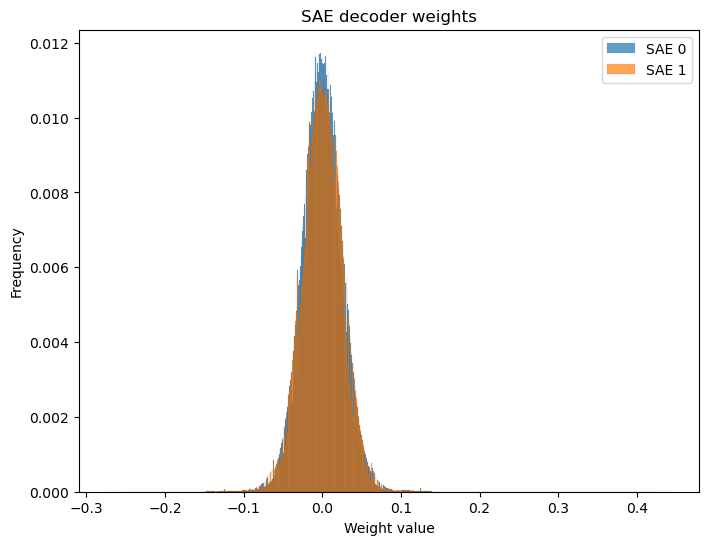

In [89]:
"""Visualize decoder weights."""

n_inst = sae.cfg.n_instances

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

### Validate feature sparsity (L0)

In [90]:
"""Validate SAE feature sparsity."""

n_units = spike_counts.shape[1]
n_examples = spike_counts.shape[0]
batch_sz = 1024
seq_len = 1
n_steps = spike_counts.shape[0] // batch_sz
n_recon_examples = n_steps * batch_sz
valid_starts = n_examples - seq_len + 1
l0 = t.zeros(((n_steps * batch_sz), n_inst), dtype=t.float32, device=device)
recon_spk_cts = t.empty((n_recon_examples, n_inst, n_units), dtype=bfloat16, device=device)
# all_acts = t.empty((n_recon_examples, n_inst, sae.cfg.n_hidden_ae), dtype=bfloat16, device=device)

progress_bar = tqdm(range(n_steps))
with t.no_grad():
    for step in progress_bar:
        # Get proper indices corresponding to step
        idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
        idxs = repeat(idxs, "batch -> batch inst", inst=n_inst)
        # broadcast idxs for each sequence to a new dimension
        seq_idxs = idxs.unsqueeze(-1) + t.arange(seq_len)
        spike_count_seqs = spike_counts[seq_idxs]
        spike_count_seqs = rearrange(  # format for Sae
            spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
        )
        x_prime, z = sae.forward(spike_count_seqs)
        nonzero_mask = (z.abs() > 1e-7).float()
        cur_l0 = reduce(nonzero_mask, "batch inst sae_feat -> batch inst", "sum")
        l0[idxs[:, 0]] = cur_l0
        recon_spk_cts[idxs[:, 0]] = x_prime
        # all_acts[idxs[:, 0]] = z

# all_acts = asnumpy(all_acts.float())

  0%|          | 0/178 [00:00<?, ?it/s]

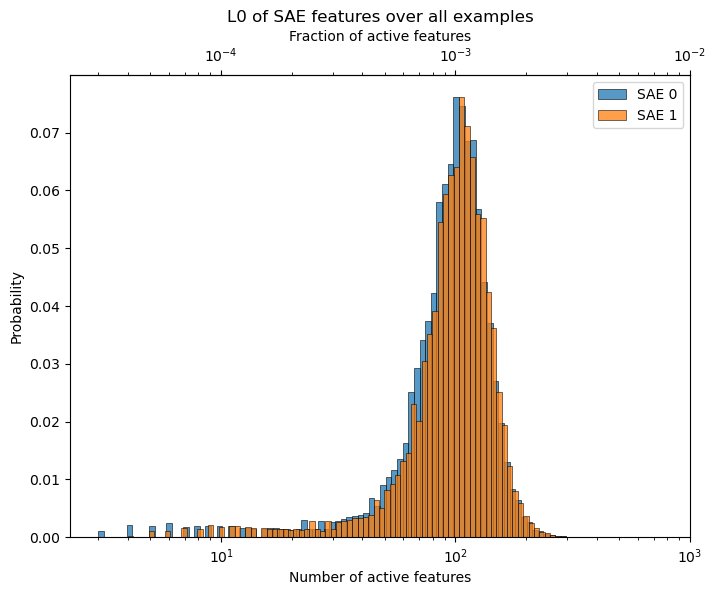

In [91]:
fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    sns.histplot(
        asnumpy(l0[:, inst]),
        bins=100,
        log_scale=10,
        stat="probability",
        ax=ax,
        label=f"SAE {inst}"
    )

ax.set_xlabel("Number of active features")
ax.set_ylabel("Probability")

secax = ax.secondary_xaxis(
    "top", 
    functions=(lambda x: x / sae.cfg.n_hidden_ae, lambda x: x * sae.cfg.n_hidden_ae)
)
secax.set_xlabel('Fraction of active features')

ax.set_title("L0 of SAE features over all examples")
ax.legend(["SAE 0", "SAE 1"])

### Validate that the reconstructions are good

In [92]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spike_counts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.954
SAE instance 1 R² (summed spike count over all units per example) = 0.955


In [ ]:
"""Calculate var explained for each neuron."""

r2_neuron = np.empty((n_inst, n_units))
for inst in range(n_inst):
    for unit in range(n_units):
        r2_neuron[inst, unit] = r2_score(
            asnumpy(spike_counts[0:n_recon_examples, unit].float()),
            asnumpy(recon_spk_cts[:, inst, unit].float())
        )
data = [r2_neuron[i] for i in range(n_inst)]

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(
    data=data,
    width=0.3,
    showfliers=False,
    showmeans=True,
    meanprops={
        "markeredgecolor": "white",
        "markerfacecolor": "white",
        "markersize": "6"
    },
    ax=ax
)
sns.stripplot(
    data=data,
    alpha=0.6,
    jitter=True,
    dodge=True,
    ax=ax,
)

# Customize the plot labels and title
ax.set_xlabel("SAE Instance")
ax.set_ylabel("$R^2$ score")
ax.set_title("Unit-to-unit R² scores")
ax.set_xticklabels([f"SAE {i}" for i in range(n_inst)])
# ax.set_yticks(np.arange(-0.6, 1.1, 0.1))
# ax.set_ylim(-0.6, 1.0)
ax.grid(True)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [1]:
r2_thresh = 0.2
n_units_gt_r2_thresh = sum(data[0] > r2_thresh)
frac_units_gt_r2_thresh = n_units_gt_r2_thresh / n_units
print(f"{n_units_gt_r2_thresh=}, {frac_units_gt_r2_thresh=}")

NameError: name 'data' is not defined

In [95]:
"""Calculate cosine similarity between recon and actual for each exmample."""

batch_sz = 128
n_steps = spike_counts.shape[0] // batch_sz
n_recon_examples = n_steps * batch_sz
cos_sim = t.empty((n_recon_examples, n_inst)).to(device)

# This requires too mach memory, so we have to batch it.
# for inst in range(n_inst):
#   cos_sim[:, inst] = F.cosine_similarity(
#       rearrange(spike_counts[0:n_recon_examples], "example unit -> example 1 unit"),
#       recon_spk_cts[:, inst, :],
#       dim=2,
#   )

pbar = tqdm(range(n_steps))
for step in pbar:
    # Get proper indices corresponding to step
    idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
    cos_sim[idxs, :] = t.cosine_similarity(
        repeat(spike_counts[idxs, :], "example unit -> example inst unit", inst=n_inst),
        recon_spk_cts[idxs, :, :],
        dim=2
    ).float()

cos_sim = asnumpy(cos_sim)

  0%|          | 0/1428 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


NameError: name 'cos_sim' is not defined

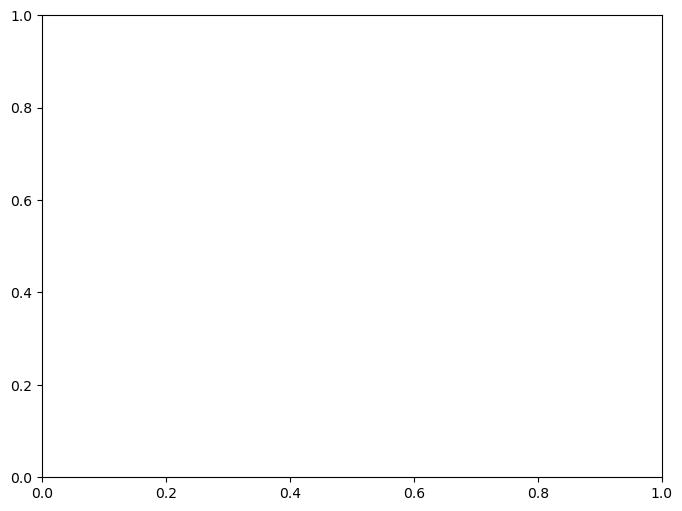

In [34]:
"""Plot cosine similarities."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    sns.histplot(cos_sim[:, inst], bins=1000, stat="probability", ax=ax, label=f"SAE {inst}")

ax.set_xlabel("Cosine similarity")
ax.set_ylabel("Probability")
ax.set_title("Cosine similarity between actual and reconstructed spike counts")
ax.legend(["SAE 0", "SAE 1"])
ax.set_xlim(0.4, 1.0)

## Scratchpad below here

In [ ]:
def batched_forward_pass(
    spike_counts: Int[Tensor, "n_examples n_units"],
    sae: Sae, 
    batch_sz: int, 
    seq_len: int, 
    device: str = "cuda"
) -> tuple[
    Int[Tensor, "n_examples n_inst"], 
    Float[Tensor, "n_examples n_inst n_units"], 
    Float[Tensor, "n_examples n_inst n_hidden_ae"],
    Float[Tensor, "n_examples n_inst"],
    Float[Tensor, "n_examples n_inst"],
    Float[Tensor, "n_examples n_inst"]
]:
    """Perform batched forward pass through SAE model.
    
    Returns a tuple containing:
        - L0 (number of active features per example)
        - Reconstructed spike counts per example
        - Hidden layer activations per example
        - L1 loss per example
        - L2 loss per example
        - Total loss per example
    """
    # Initialize batches.
    n_examples, n_units = spike_counts.shape[0], spike_counts.shape[1]
    n_inst = sae.cfg.n_instances
    n_full_batches, final_batch_sz = n_examples // batch_sz, n_examples % batch_sz
    n_steps = n_full_batches + (1 if final_batch_sz > 0 else 0)
    
    # Initialize output tensors.
    l0 = t.zeros((n_examples, n_inst), dtype=t.float32, device=device)
    recon_spk_cts = t.empty((n_examples, n_inst, n_units), dtype=t.bfloat16, device=device)
    h_acts = t.empty((n_examples, n_inst, sae.cfg.n_hidden_ae), dtype=t.bfloat16, device=device)
    l1_losses = t.empty((n_examples, n_inst), dtype=t.bfloat16, device=device)
    l2_losses = t.empty((n_examples, n_inst), dtype=t.bfloat16, device=device)
    total_losses = t.empty((n_examples, n_inst), dtype=t.bfloat16, device=device)
    
    progress_bar = tqdm(range(n_steps))
    with t.no_grad():
        for step in progress_bar:
            # Set up for forward pass.
            cur_batch_size = batch_sz if step < n_full_batches else final_batch_sz
            start_idx = step * batch_sz
            end_idx = start_idx + cur_batch_size
            idxs = t.arange(start_idx, end_idx)
            idxs = repeat(idxs, "batch -> batch inst", inst=n_inst)
            # broadcast idxs for each sequence to a new dimension
            seq_idxs = idxs.unsqueeze(-1) + t.arange(seq_len)
            spike_count_seqs = spike_counts[seq_idxs]
            spike_count_seqs = rearrange(
                spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
            )
            
            # Compute reconstructions, hidden layer activations, and losses.
            l1_loss, l2_loss, loss, z, x_prime = sae.forward(spike_count_seqs)
            
            # Compute L0.
            nonzero_mask = (z.abs() > 1e-7).float()
            cur_l0 = reduce(nonzero_mask, "batch inst sae_feat -> batch inst", "sum")
            
            # Store results
            l0[idxs[:, 0]] = cur_l0
            recon_spk_cts[idxs[:, 0]] = x_prime
            h_acts[idxs[:, 0]] = z
            l1_losses[idxs[:, 0]] = l1_loss
            l2_losses[idxs[:, 0]] = l2_loss
            total_losses[idxs[:, 0]] = loss
    
    return l0, recon_spk_cts, h_acts, l1_losses, l2_losses, total_losses

## Initial Sweeps

This is all assuming 100-400 units over ~ 2e5 to 1e6 examples.

### Neural data

- Time window size (50 ms -- fixed for now)
- Unit preprocessing (remove units with firing rate < 0.5 Hz, isi violations > 0.1 -- fixed for now)
- Sequence length -- feed in previous info, but only try to reconstruct current info: (0 - 4 previous windows)

### SAEs

- Number of neurons: (5e3, 1e4, 2e4, 5e4, 1e5)
- Optimizer learning rate: (lr: 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
- LR schedule (simple cosine cycle): (true, false)
- Loss functions
    - Batchtopk SAE (k: 25, 50, 100, 200)
        - L2 loss MSE
        - L2 loss LMSE (t: 0.9, 0.95, 1, 1.05, 1.1)

Report during sweep:

- loss
- some properties of L0 distribution per batch
- frac_dead

Report end of sweep:

- R^2 of summed spike counts
- frac_dead
- R^2 for each neuron over all examples (plot)
- histogram of L0  over all examples (plot)

---


- One job for each loss for each d_sae-topk pair (20 jobs: 6 * 6 = 36 sweeps per run)